In [ ]:
'''
Take weight matrix parameters(input weights, recurrent weights and output weights) 
spike_raster from 10 and instantiate a trained network. 
    1- Jitter first 10ms of spikes each with a random num (-4,4). 
    Run the network once, substituting the jittered spikes for the first 10 ms manually in the forward function.
    2- Jitter all spikes of the network and plot the spike raster'''

In [1]:
import os
import torch
import snntorch as snn
import matplotlib.pyplot as plt
from snntorch import surrogate
from snntorch import spikegen
from snntorch import functional
from snntorch import LIF
from snntorch import spikeplot as splt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
from warnings import warn
import torch.nn as nn
import csv

In [2]:
from classes.Sine_Wave_Dataset import SineWave1 #changing amp and per with resetting clock
from classes.Custom_Loss import CustomLoss_task
# from classes import RSNN3,train1

In [3]:
#import the trained recurrent matrix and output patrix
data_dir = 'dataMP'
file_name = 'level1_loss0_epoch480_batch39.npz'
file_path = os.path.join(data_dir, file_name)

if os.path.exists(file_path):
        data = np.load(file_path)
        #shape 200x200 and 1x200,epoch 480, batch 39, training data 24
        l1_mx = torch.from_numpy(data['input_weights']).T  #2x200
        rec_mx = torch.from_numpy(data['rec_weights']).T #200x200
        l2_mx = torch.from_numpy(data['output_weights']).T #200x1
        inputs = torch.from_numpy(data['inputs'][-1]).T
        spikes = torch.from_numpy(data['spikes'])
        targets = data['targets'][-1]
        outputs = data['outputs'][-1]
        
print(spikes.shape)


torch.Size([200, 300])


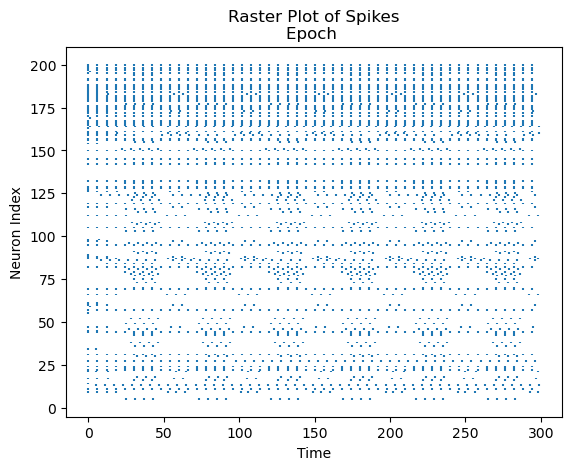

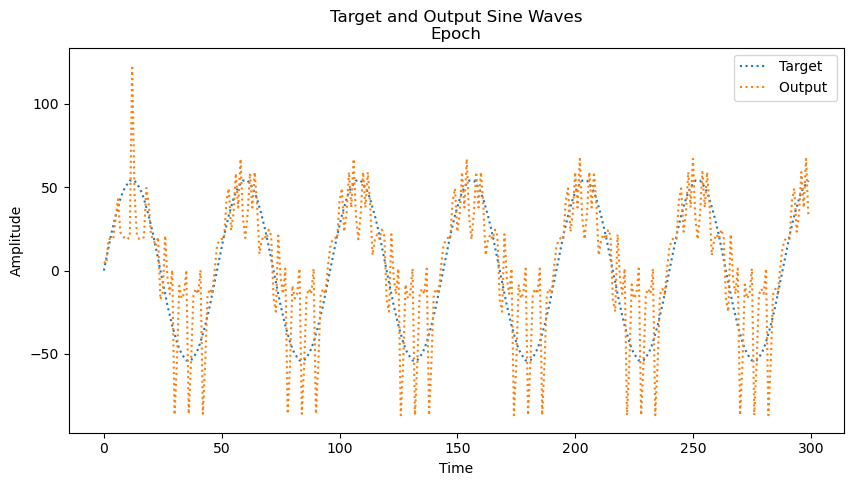

In [4]:
import matplotlib.pyplot as plt
# print(spikes[:10,:20])

for neuron, spike_train in enumerate(spikes):
    spike_times = np.where(spike_train > 0)[0]  # Assuming spikes are indicated by positive values
    plt.vlines(spike_times, neuron + 0.5, neuron + 1.5)

plt.title(f'Raster Plot of Spikes\nEpoch ')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(targets, linestyle='dotted',label=f'Target')
plt.plot(outputs, linestyle='dotted', label=f'Output ')

plt.title(f'Target and Output Sine Waves\nEpoch')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [5]:
import random
def generate_nonzero_random():
    while True:
        num = int(random.uniform(1, 5))  # Generate a random float between -4 and 4
        if num != 0:
            return num
        
spikes1 = torch.zeros([200,300])
# print(spikes[:20,:10])
for neur in range(200):
    for timestep in range(10):
        if spikes[neur,timestep] == 1:
            jitter = generate_nonzero_random()
            # print(jitter)
            if (timestep+jitter >= 0) & (timestep+jitter < 10):
                # spikes1[neur,timestep] = 0
                spikes1[neur,timestep+jitter] = 1
# print(spikes1[:20,:10])
                

In [7]:
print(l1_mx.shape)

torch.Size([3, 200])


In [8]:
from classes.helper1 import conn_mx, hid_mx
from classes.RLIF1 import RLIF1


#set the rec_mx and output layer matrix to already trained model (trained on sinewave0 dataloader train_data_hpc0)
#set the input layer 3x200: first row to first row, and third row to second row of the trained model
class RSNN80(nn.Module):
    def __init__(self):
        super(RSNN80, self).__init__()
        num_inputs = 3
        num_hidden = 200
        num_output = 1
        beta = 0.85
        pe_e = 0.16

        # Define the dimensions
        num_excitatory = 160
        self.num_excitatory = num_excitatory
        num_inhibitory = 40
        self.false_neg = []
        self.false_pos = []

        #input to hidden layer
        # input_hid_mx = conn_mx(num_inputs, num_hidden, pe_e)
        # input_hid_mx= l1_mx 
        # self.input_hid_mx = input_hid_mx
        self.l1 = nn.Linear(num_inputs,num_hidden)
        self.l1.weight.data = l1_mx.T

        # Recurrent layer weight matrix        
        self.rlif1 = RLIF1(reset_mechanism="zero", beta=beta, threshold=1.0,linear_features=num_hidden, all_to_all=True)
        self.rlif1.recurrent.weight.data = rec_mx.T

        #hidden to output layer
        # hid_out_mx = conn_mx(num_hidden,num_output,pe_e)
        self.l2 = nn.Linear(num_hidden, num_output)
        self.l2.weight.data = l2_mx.T
        
        self.spk1_rec = []
        self.cur2_rec = []
        self.spk1,self.mem1 = self.rlif1.init_rleaky()


    def forward(self, inputs, spk1, mem1):
        cur1 = self.l1(inputs)
        spk1, mem1 = self.rlif1(cur1, spk1, mem1)
        cur2 = self.l2(spk1)
        
        self.mem1 = mem1
        

        return cur2, spk1, mem1


In [9]:
# Initialize spikes and membrane potentials
net_80 = RSNN80()
spk1 = net_80.spk1
mem1 = net_80.mem1
spk_list = []
mem_list = []

In [10]:
#jitter the spikes, and run the network. on the initial spikes. 
for i in range(300):
    
    if i < 10:
        spk1 = spikes1[:, i]
        net_80.spk1_rec.append(spk1)
        mem1 = net_80.mem1  # Update membrane potential if needed
        cur2, spk1, mem1 = net_80.forward(inputs[:, i], spk1, mem1)
        net_80.cur2_rec.append(cur2)
    else:
        # For the remaining timesteps, run the network normally
        cur2, spk1, mem1 = net_80.forward(inputs[:, i], spk1, mem1)
        net_80.spk1_rec.append(spk1)
        net_80.cur2_rec.append(cur2)

# Convert recorded spikes and currents to tensors
spk1_rec = torch.stack(net_80.spk1_rec).T
cur2_rec = torch.stack(net_80.cur2_rec)

torch.Size([200, 300])


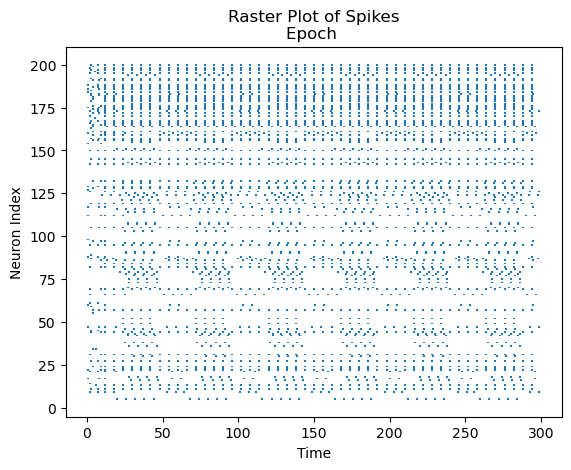

In [12]:
# Plot the spike raster
import matplotlib.pyplot as plt

print(spk1_rec.shape)

for neuron, spike_train in enumerate(spk1_rec):
    spike_times = np.where(spike_train > 0)[0]  # Assuming spikes are indicated by positive values
    plt.vlines(spike_times, neuron + 0.5, neuron + 1.5)

plt.title(f'Raster Plot of Spikes\nEpoch ')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.show()

In [14]:
l2_mx = l2_mx.to(float)
spk1_rec = spk1_rec.to(float)
output = torch.matmul(spk1_rec.T, l2_mx)
targets = data['targets'][24]
      

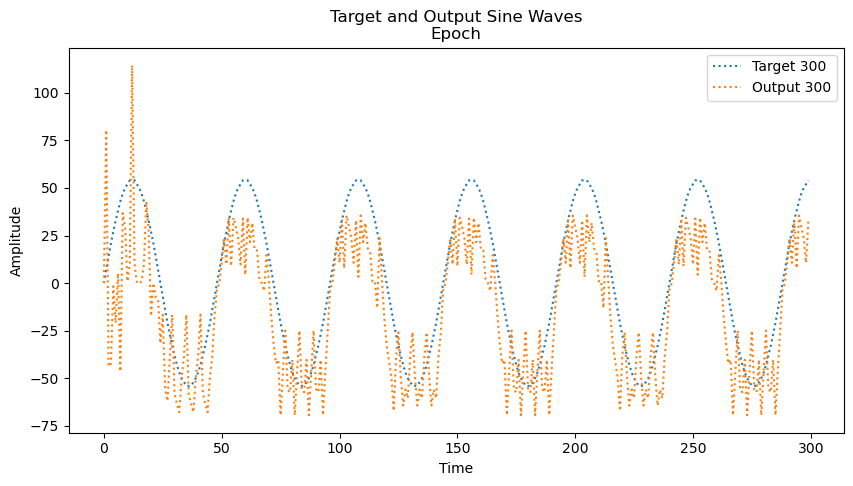

In [15]:
output = output.squeeze().detach().numpy()

plt.figure(figsize=(10, 5))
plt.plot(targets, linestyle='dotted',label=f'Target {i+1}')
plt.plot(output, linestyle='dotted', label=f'Output {i+1}')

plt.title(f'Target and Output Sine Waves\nEpoch')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [16]:
spikes1 = torch.zeros([200,300])
for neur in range(200):
    for timestep in range(300):
        if spikes[neur,timestep] == 1:
            jitter = generate_nonzero_random()
            # print(jitter)
            if (timestep+jitter >= 0) & (timestep+jitter < 300):
                # spikes1[neur,timestep] = 0
                spikes1[neur,timestep+jitter] = 1

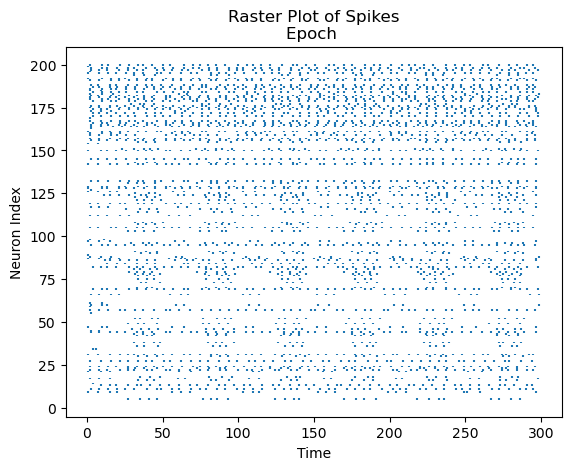

In [17]:
for neuron, spike_train in enumerate(spikes1):
    spike_times = np.where(spike_train > 0)[0]  # Assuming spikes are indicated by positive values
    plt.vlines(spike_times, neuron + 0.5, neuron + 1.5)

plt.title(f'Raster Plot of Spikes\nEpoch ')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.show()

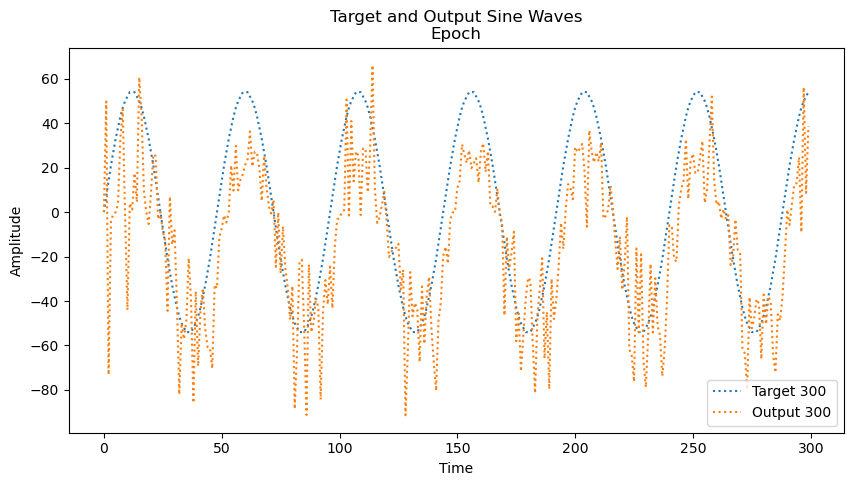

In [18]:
l2_mx = l2_mx.to(float)
spikes1 = spikes1.to(float)
output = torch.matmul(spikes1.T, l2_mx)
targets = data['targets'][24]
output = output.squeeze().detach().numpy()

plt.figure(figsize=(10, 5))
plt.plot(targets, linestyle='dotted',label=f'Target {i+1}')
plt.plot(output, linestyle='dotted', label=f'Output {i+1}')

plt.title(f'Target and Output Sine Waves\nEpoch')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()